In [1]:
import os
import torch
import torchaudio
from einops import rearrange
from stable_audio_tools import get_pretrained_model
from stable_audio_tools.inference.generation import generate_diffusion_cond
from IPython.display import Audio, display
import inspect

# re-run with next line uncommented to shrink .ipynb file size for sharing. 
#Audio = lambda x, rate=None: None # overwite for now 


device = "cuda" if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else "cpu"
print(device)

mps


/Users/shawley/github/sao-guidance/.venv/lib/python3.10/site-packages/clip/clip.py:6: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import packaging


In [2]:
# Download model
model, model_config = get_pretrained_model("stabilityai/stable-audio-open-small")
sample_rate = model_config["sample_rate"]
sample_size = model_config["sample_size"]

model = model.to(device)
autoencoder = model._modules['pretransform']._modules.get("model")

No module named 'flash_attn'
flash_attn not installed, disabling Flash Attention


/Users/shawley/github/sao-guidance/.venv/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:144: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


# Unguided Generation, No Init Audio

In [3]:
conditioning = [{
    "prompt": "beginner saxophone practice ascending chromatic scale",
    "seconds_total": 10
}]
seed = 0 

# Generate stereo audio
output_noguidance = generate_diffusion_cond(
    model,
    # Marco's Notes:
    # 7 steps works good for sao small, higher than that gets scary
    # If using normal sao higher steps is usually pretty good.
    steps=8,
    cfg_scale=1, # Config of 1 often good for small, higher works on normal
    conditioning=conditioning,
    sample_size=sample_size,
    sigma_min=.3,
    sigma_max=500,
    #sampler_type="dpmpp-3m-sde",  # Use this for normal open
    sampler_type="pingpong",  # Use this for small
    device=device,
    callback=None,
    seed=seed,
)
output=output_noguidance
print(f"output norm = {output.norm().item():.4f}")
output = rearrange(output, "b d n -> d (b n)")

0


/Users/shawley/github/sao-guidance/.venv/lib/python3.10/site-packages/torch/backends/__init__.py:46: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/Context.cpp:85.)
  self.setter(val)
/Users/shawley/github/sao-guidance/.venv/lib/python3.10/site-packages/stable_audio_tools/models/conditioners.py:362: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(dtype=torch.float16) and torch.set_grad

output norm = 322.3327


Let's look at the chroma features of this unguided generation:

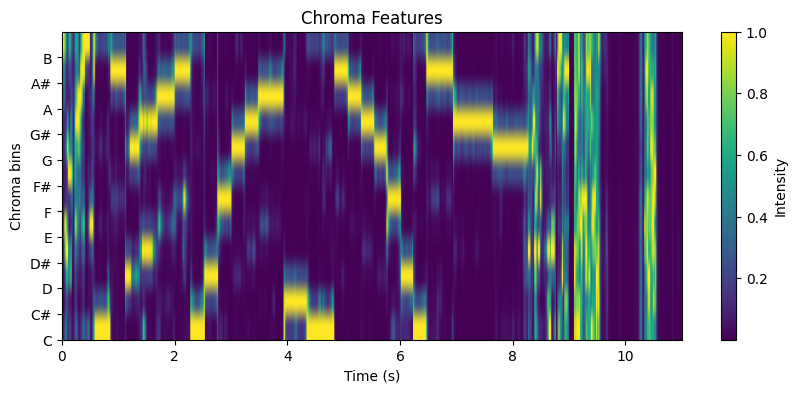

None

In [4]:
from torch import nn
import typing as tp
from librosa import filters
import matplotlib.pyplot as plt
import einops
import numpy as np
import julius
import torchmetrics

class ChromaExtractor(nn.Module):
    
    """
    Chroma extraction and quantization.

    Args:
        sample_rate (int): Sample rate for the chroma extraction.
        n_chroma (int): Number of chroma bins for the chroma extraction.
        radix2_exp (int): Size of stft window for the chroma extraction (power of 2, e.g. 12 -> 2^12).
        nfft (int, optional): Number of FFT.
        winlen (int, optional): Window length.
        winhop (int, optional): Window hop size.
        argmax (bool, optional): Whether to use argmax. Defaults to False.
        norm (float, optional): Norm for chroma normalization. Defaults to inf.
    """

    def __init__(self, sample_rate: int, n_chroma: int = 12, radix2_exp: int = 12, nfft: tp.Optional[int] = None,
                 winlen: tp.Optional[int] = None, winhop: tp.Optional[int] = None, argmax: bool = False,
                 norm: float = torch.inf):
        super().__init__()
        self.winlen = winlen or 2 ** radix2_exp
        self.nfft = nfft or self.winlen
        self.winhop = winhop or (self.winlen // 4)
        self.sample_rate = sample_rate
        self.n_chroma = n_chroma
        self.norm = norm
        self.argmax = argmax
        self.register_buffer('fbanks', torch.from_numpy(filters.chroma(sr=sample_rate, n_fft=self.nfft, tuning=0,
                                                                       n_chroma=self.n_chroma)), persistent=False)
        self.spec = torchaudio.transforms.Spectrogram(n_fft=self.nfft, win_length=self.winlen,
                                                      hop_length=self.winhop, power=2, center=True,
                                                      pad=0, normalized=True)

    def forward(self, wav: torch.Tensor) -> torch.Tensor:
        T = wav.shape[-1]
        # in case we are getting a wav that was dropped out (nullified)
        # from the conditioner, make sure wav length is no less that nfft
        if T < self.nfft:
            pad = self.nfft - T
            r = 0 if pad % 2 == 0 else 1
            wav = torch.nn.functional.pad(wav, (pad // 2, pad // 2 + r), 'constant', 0)
            assert wav.shape[-1] == self.nfft, f"expected len {self.nfft} but got {wav.shape[-1]}"

        spec = self.spec(wav).squeeze(1)
        raw_chroma = torch.einsum('cf,...ft->...ct', self.fbanks, spec)
        norm_chroma = torch.nn.functional.normalize(raw_chroma, p=self.norm, dim=-2, eps=1e-6)
        norm_chroma = einops.rearrange(norm_chroma, 'b d t -> b t d')

        if self.argmax:
            idx = norm_chroma.argmax(-1, keepdim=True)
            norm_chroma[:] = 0
            norm_chroma.scatter_(dim=-1, index=idx, value=1)

        return norm_chroma



def plot_chromagram(chroma, sample_rate, duration=11.0):
    # Get parameters

    # Compute time axis (in seconds)
    times = np.arange(duration+1)

    plt.figure(figsize=(10, 4))
    plt.imshow(chroma[0].T.cpu(),  aspect='auto',  origin='lower',  extent=[times[0], times[-1], 0, 12])
    plt.xlabel('Time (s)')
    plt.ylabel('Chroma bins')
    plt.title('Chroma Features')

    # Set y-axis labels to note names
    note_labels = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']

    plt.yticks(ticks=range(len(note_labels)), labels=note_labels)
    plt.colorbar(label='Intensity')
    plt.show()


chroma_extractor = ChromaExtractor(sample_rate=sample_rate, argmax=False).to(device)
plot_chromagram(chroma_extractor(output), sample_rate)

# Peak normalize, convert to int16
cleaned_output = output.to(torch.float32).div(torch.max(torch.abs(output))).clamp(-1, 1).mul(32767).to(torch.int16).cpu()
display(Audio(cleaned_output.cpu().numpy(), rate=sample_rate))

# Unguided Generation with Init Audio

## Load & Inspect Input Audio for Guidance and/or Init Audio

torch.Size([2, 524288])
44100


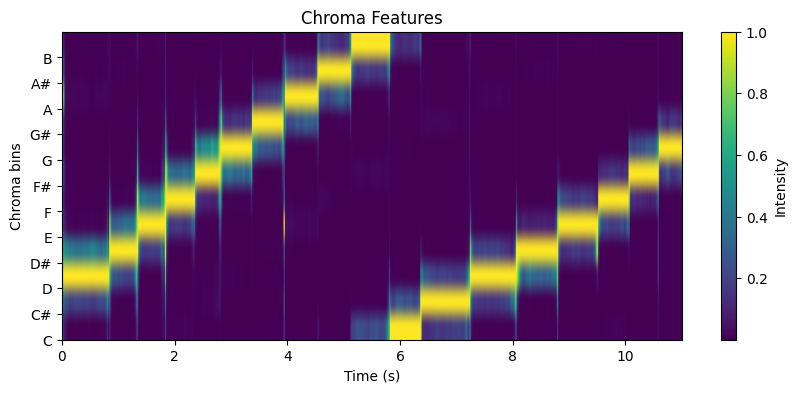

None

In [5]:
# this will be the guidance signal 
target_audio_path = f"panflute_fast.wav"
if not os.path.exists(target_audio_path): 
    !wget -q http://hedges.belmont.edu/data/{target_audio_path}

wav, sr = torchaudio.load(target_audio_path)
wav = wav.to(device)


def trim_audio_seconds(wav: torch.Tensor, sample_rate: int, duration_s: float):
    """Trim (or pad) an audio tensor to the desired duration in seconds."""
    target_len = int(sample_rate * duration_s)
    wav = wav[..., :target_len]  # Trim
    return wav
    
wav = trim_audio_seconds(wav, sample_rate=sr, duration_s=11.888616780045352)
print(wav.shape)
print(sr)

plot_chromagram(chroma_extractor(wav), sr)
display(Audio(wav.cpu().numpy(), rate=sr))

## Generate with only Init Audio, No Guidance

/Users/shawley/github/sao-guidance/.venv/lib/python3.10/site-packages/stable_audio_tools/models/conditioners.py:362: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(dtype=torch.float16) and torch.set_grad_enabled(self.enable_grad):
/Users/shawley/github/sao-guidance/.venv/lib/python3.10/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


0


100%|███████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 11.09it/s]


output norm = 684.1675
Final Result:


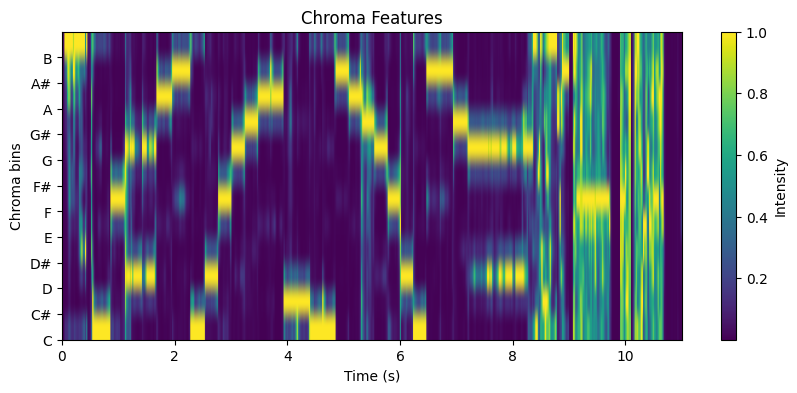

None

In [6]:
init_audio = (sr, wav)
init_noise_level=0.98

# Generate stereo audio
output_noguidance = generate_diffusion_cond(
    model,
    # Marco's Notes:
    # 7 steps works good for sao small, higher than that gets scary
    # If using normal sao higher steps is usually pretty good.
    steps=8,
    cfg_scale=1, # Config of 1 often good for small, higher works on normal
    conditioning=conditioning,
    sample_size=sample_size,
    sigma_min=.3,
    sigma_max=500,
    init_audio=init_audio,
    init_noise_level=init_noise_level,
    #sampler_type="dpmpp-3m-sde",  # Use this for normal open
    sampler_type="pingpong",  # Use this for small
    device=device,
    callback=None,
    seed=seed,
)
output=output_noguidance
print(f"output norm = {output.norm().item():.4f}")
output = rearrange(output, "b d n -> d (b n)")

print("Final Result:")
plot_chromagram(chroma_extractor(output), sample_rate)
# Peak normalize, convert to int16
cleaned_output = output.to(torch.float32).div(torch.max(torch.abs(output))).clamp(-1, 1).mul(32767).to(torch.int16).cpu()
display(Audio(cleaned_output.numpy(), rate=sample_rate))

# Setup for Guidance

## Guidance Critera (Loss)

MSE loss and/or...

In [7]:

class ChromaCosineSimilarityMetric(torchmetrics.Metric):
    
    """
    Chroma cosine similarity metric.

        This metric extracts a chromagram for a reference waveform and
        a generated waveform and compares each frame using the cosine similarity
        function. The output is the mean cosine similarity.

        Args:
            sample_rate (int): Sample rate used by the chroma extractor.
            n_chroma (int): Number of chroma used by the chroma extractor.
            radix2_exp (int): Exponent for the chroma extractor.
            argmax (bool): Whether the chroma extractor uses argmax.
            eps (float): Epsilon for cosine similarity computation.
    """

    def __init__(self, sample_rate: int, n_chroma: int, radix2_exp: int, argmax: bool, eps: float = 1e-8):
        super().__init__()
        self.chroma_sample_rate = sample_rate
        self.n_chroma = n_chroma
        self.eps = eps
        self.chroma_extractor = ChromaExtractor(sample_rate=self.chroma_sample_rate, n_chroma=self.n_chroma,
                                                radix2_exp=radix2_exp, argmax=argmax)
        self.add_state("cosine_sum", default=torch.tensor(0.), dist_reduce_fx="sum")
        self.add_state("weight", default=torch.tensor(0.), dist_reduce_fx="sum")

    @torch.enable_grad()
    def update(self, preds: torch.Tensor, targets: torch.Tensor,
               sizes: torch.Tensor, sample_rates: torch.Tensor) -> None:
        """Compute cosine similarity between chromagrams and accumulate scores over the dataset."""
        if preds.size(0) == 0:
            return

        assert preds.shape == targets.shape, (
            f"Preds and target shapes mismatch: preds={preds.shape}, targets={targets.shape}")
        assert preds.size(0) == sizes.size(0), (
            f"Number of items in preds ({preds.shape}) mismatch ",
            f"with sizes ({sizes.shape})")
        assert preds.size(0) == sample_rates.size(0), (
            f"Number of items in preds ({preds.shape}) mismatch ",
            f"with sample_rates ({sample_rates.shape})")
        assert torch.all(sample_rates == sample_rates[0].item()), "All sample rates are not the same in the batch"

        device = self.weight.device
        preds, targets = preds.to(device), targets.to(device)  # type: ignore
        sample_rate = sample_rates[0].item()
        preds = convert_audio(preds, from_rate=sample_rate, to_rate=self.chroma_sample_rate, to_channels=1)
        targets = convert_audio(targets, from_rate=sample_rate, to_rate=self.chroma_sample_rate, to_channels=1)
        gt_chroma = self.chroma_extractor(targets)
        gen_chroma = self.chroma_extractor(preds)
        chroma_lens = (sizes / self.chroma_extractor.winhop).ceil().int()
        for i in range(len(gt_chroma)):
            t = int(chroma_lens[i].item())
            cosine_sim = torch.nn.functional.cosine_similarity(
                gt_chroma[i, :t], gen_chroma[i, :t], dim=1, eps=self.eps)
            self.cosine_sum += cosine_sim.sum(dim=0)  # type: ignore
            self.weight += torch.tensor(t)  # type: ignore

    @torch.enable_grad()
    def compute(self) -> float:
        """Computes the average cosine similarty across all generated/target chromagrams pairs."""
        assert self.weight.item() > 0, "Unable to compute with total number of comparisons <= 0"  # type: ignore
        return (self.cosine_sum / self.weight)#.item()  # type: ignore
    
def convert_audio(wav: torch.Tensor, from_rate: float,
                  to_rate: float, to_channels: int) -> torch.Tensor:
    """Convert audio to new sample rate and number of audio channels."""
    wav = julius.resample_frac(wav, int(from_rate), int(to_rate))
    wav = convert_audio_channels(wav, to_channels)
    return wav




def convert_audio_channels(wav: torch.Tensor, channels: int = 2) -> torch.Tensor:

    *shape, src_channels, length = wav.shape
    if src_channels == channels:
        pass
    elif channels == 1:
        # Case 1:
        # The caller asked 1-channel audio, and the stream has multiple
        # channels, downmix all channels.
        wav = wav.mean(dim=-2, keepdim=True)
    elif src_channels == 1:
        # Case 2:
        # The caller asked for multiple channels, but the input file has
        # a single channel, replicate the audio over all channels.
        wav = wav.expand(*shape, channels, length)
    elif src_channels >= channels:
        # Case 3:
        # The caller asked for multiple channels, and the input file has
        # more channels than requested. In that case return the first channels.
        wav = wav[..., :channels, :]
    else:
        # Case 4: What is a reasonable choice here?
        raise ValueError('The audio file has less channels than requested but is not mono.')
    return wav

## Guidance CallBack 

In [8]:
import torch.nn.functional as F 

def chroma_guidance_callback(autoencoder, target_audio, strength, in_dict):
    "Main guidance routine using chroma features" 
    t, x, denoised = in_dict['t'], in_dict['x'], in_dict['denoised'] 
    if target_audio is None: 
        print(f"t = {t:.3f}: target_audio is None. Skipping chroma guidance callback")
        return 
    chroma_targ = chroma_extractor(target_audio).to(device)
    print('--')
    with torch.enable_grad():
        inner_steps = 1
        inner_strength = strength / inner_steps  
        for step in range(inner_steps):
            denoised.requires_grad_(True)  # Enable grad on denoised itself
            pred_audio = autoencoder.decoder(denoised.half())
            shape_save = pred_audio.shape[-1]
            kernel_size = 64
            pred_audio = torch.nn.functional.avg_pool1d(
                pred_audio, kernel_size=kernel_size, stride=1, padding=kernel_size//2
            )
            pred_audio = pred_audio[..., :shape_save]
            #print("pred_audio.shape =",pred_audio.shape)
            # pred_audio = torchaudio.functional.lowpass_biquad(
            #     pred_audio, sample_rate=sample_rate, cutoff_freq=4000)
            pred_audio = rearrange(pred_audio, "b d n -> d (b n)")
            chroma_pred = chroma_extractor(pred_audio)
            plot_chromagram(chroma_pred.detach(), sample_rate)
            loss = F.mse_loss(chroma_pred, chroma_targ)
            grad = torch.autograd.grad(loss, denoised)[0]
            #gamma_t = (1 - t)
            #gamma_t = 0.3 + 0.7 * (1 - t)  # Goes from 0.3 → 1.0
            gamma_t = 1.0 
            
            # gradient clipping and update
            with torch.no_grad():
                #if grad.norm() > 0.1:
                #    grad = grad * (0.1 / grad.norm())
                denoised -= inner_strength * gamma_t * grad
                denoised.requires_grad_(False)
            
            print(f"  Inner step {step}: loss={loss.item():.6f}")

In [9]:
# def chroma_guidance_callback_old(autoencoder, target_audio, strength, in_dict):
#     "Main guidance routine using chroma features" 
#     t, x, denoised = in_dict['t'], in_dict['x'], in_dict['denoised'] 
#     if target_audio is None: 
#         print(f"t = {t:.3f}: target_audio is None. Skipping chroma guidance callback")
#         return 
#     # Compute chroma features
#     with torch.enable_grad():
#         x.requires_grad, denoised.requires_grad = True, True 
#         print(f"t = {t:.3f}") 
    
#         # Convert latent -> waveform
#         pred_audio = autoencoder.decoder(denoised.half())
#         pred_audio = rearrange(pred_audio, "b d n -> d (b n)")
    
#         # Create chroma metric/loss
#         chroma_metric = ChromaCosineSimilarityMetric(
#             sample_rate=autoencoder.sample_rate,
#             n_chroma=12,
#             radix2_exp=12,
#             argmax=False
#         )
    
#         # Fake wrappers for batch info
#         B = pred_audio.shape[0]
#         sizes = torch.tensor([pred_audio.shape[-1]] * B, device=pred_audio.device)
#         sample_rates = torch.tensor([44100] * B, device=pred_audio.device)

#         # Compute similarity
#         chroma_metric.update(pred_audio, target_audio, sizes, sample_rates)
#         similarity = chroma_metric.compute()

#         # plot_chromagram(pred_audio, sample_rate=autoencoder.sample_rate, winhop=ChromaCosineSimilarityMetric.chroma_extractor.winhop)

#         # Convert to loss (maximize similarity → minimize 1 - similarity)
#         chroma_loss = 0.05*(1-similarity).to(device)

#         # hawley trying MSE for fun:
#         chroma_pred = chroma_extractor(pred_audio).to(device)
#         chroma_targ = chroma_extractor(target_audio).to(device)
#         plot_chromagram(chroma_pred.detach(), sample_rate)
#         #plot_chromagram(chroma_targ.detach(), sample_rate) # we know this already
#         chroma_loss_mse = torch.nn.functional.mse_loss(chroma_pred, chroma_targ)
#         print(f"chroma_loss_cosine = {chroma_loss.item()}, chroma_loss_mse = {chroma_loss_mse.item()}")
#         chroma_loss =  chroma_loss + chroma_loss_mse
#         grad = torch.autograd.grad(chroma_loss, denoised, retain_graph=False, allow_unused=True)[0]

#     print(f"grad.norm = {grad.norm()}")
#     #gamma_t = 1/t # time-dependence ; Note Stable Audio uses t going from 1 down to 0. 
#     gamma_t = 1 # t**2
#     d_denoised = -strength * gamma_t * grad # positive step to maximize similarity

#     # Clip update to be max 10% of current magnitude
#     max_update = 0.2 * denoised.norm()
#     if d_denoised.norm() > max_update:
#         d_denoised = d_denoised * (max_update / d_denoised.norm())
    
#     print(f"d_denoised.norm = {torch.norm(d_denoised)}")
#     denoised += d_denoised  # need += to preserve reference to original tensor 
    
#     with torch.no_grad():
#         test_audio_before = autoencoder.decoder((denoised - d_denoised).half())
#         test_audio_after = autoencoder.decoder(denoised.half())
#         audio_change = (test_audio_after - test_audio_before).norm()
#         print(f"Audio change from gradient step: {audio_change.item()}")

#     with torch.no_grad():
#         new_audio = autoencoder.decoder(denoised.half())
#         new_audio = rearrange(new_audio, "b d n -> d (b n)")
#         chroma_new = chroma_extractor(new_audio)
#         #chroma_loss_after = torch.nn.functional.mse_loss(chroma_new, chroma_targ)
#     #print(f"Loss before: {chroma_loss.item():.6f}, after: {chroma_loss_after.item():.6f}")
#     print("new audio (after grdient step) chroma:")
#     plot_chromagram(chroma_new.detach(), sample_rate)
#     print("-------------------------")

#     x.requires_grad, denoised.requires_grad = False, False # maybe not needed but we do it anyway
#     return 

# Guided Generation

## Using Standard PingPong Integrator

In [ ]:
from functools import partial 

strength = 0.0
autoencoder = model._modules['pretransform']._modules.get("model")
#autoencoder.decoder.float()
callback_wrapper = partial(chroma_guidance_callback, autoencoder, wav, strength)

#in_sr, init_audio = init_audio
init_audio = (sr, wav)

# Generate stereo audio
output_withguidance = generate_diffusion_cond(
    model,
    # Marco's Notes:
    # 7 steps works good for sao small, higher than that gets scary
    # If using normal sao higher steps is usually pretty good.
    steps=10,
    cfg_scale=1, # Config of 1 often good for small, higher works on normal
    conditioning=conditioning,
    sample_size=sample_size,
    init_audio=init_audio,
    init_noise_level=.98,
    sigma_min=.3,
    sigma_max=500,
    #sampler_type="dpmpp-3m-sde",  # Use this for normal open
    sampler_type="pingpong",  # Use this for small
    device=device,
    callback=callback_wrapper,
    seed=seed,
)
output=output_withguidance
output = rearrange(output, "b d n -> d (b n)")
print(f"output norm = {output.norm().item():.4f}")

Final Result:


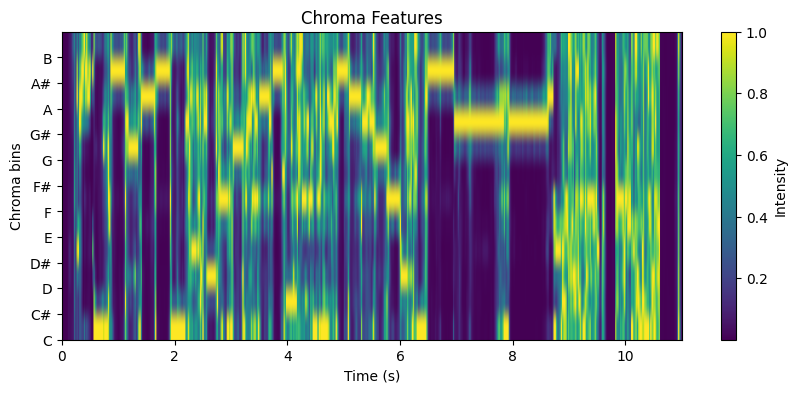

None

In [11]:
print("Final Result:")
plot_chromagram(chroma_extractor(output), sample_rate)
# Peak normalize, convert to int16
cleaned_output = output.to(torch.float32).div(torch.max(torch.abs(output))).clamp(-1, 1).mul(32767).to(torch.int16).cpu()
display(Audio(cleaned_output.numpy(), rate=sample_rate))

## PnP-Flow

### New Integrator Code for PnP-Flow

In [12]:
# Monkey-patch the pingpong integrator with new code 

from stable_audio_tools.inference import sampling
from tqdm import trange 

# @torch.no_grad()
# def sample_pnpflow(model, z0, n_steps=10, alpha=0.5, n_avg=5, warp_fn=lambda x: x, guidance_dict=None):
#     ts = warp_fn(torch.linspace(0, 1, n_steps, device=z0.device, dtype=z0.dtype))  
#     z1_hat = z0
#     for t in ts[1:]:
#         grad = guidance_dict['M_sq'] * (z1_hat - guidance_dict['y'])
#         gamma_t = (1 - t) ** alpha
#         z1_star = z1_hat - guidance_dict['strength'] * gamma_t * grad        
#         projections = []           # Average multiple noisy projections
#         for _ in range(n_avg):
#             z = t * z1_star  +  (1 - t) * torch.randn_like(z1_star) 
#             projections.append(z + (1 - t) * model(z, t))
#         z1_hat = torch.stack(projections).mean(dim=0)
#     return z1_hat

@torch.no_grad()
def sample_flow_pnpflow(model, x, steps=None, sigma_max=1, sigmas=None, callback=None, 
                        dist_shift=None, n_avg=10, **extra_args):
    """PNP-style sampling with averaged projections"""
    print(f"Using Sampler: {inspect.currentframe().f_code.co_name}")
    
    assert steps is not None or sigmas is not None, "Either steps or sigmas must be provided"
    
    ts = x.new_ones([x.shape[0]])
    
    if sigmas is None:
        t = torch.linspace(sigma_max, 0, steps + 1)
        if dist_shift is not None:
            t = dist_shift.time_shift(t, x.shape[-1])
    else:
        t = sigmas

    i = len(t) - 1
    denoised = x - t[i] * model(x, t[i] * ts, **extra_args)
    for i in trange(len(t) - 1, disable=False):
        
        # callback is going to update denoised
        if callback is not None:
            callback({'x': x, 'i': i, 't': t[i], 'sigma': t[i], 'sigma_hat': t[i], 'denoised': denoised})
        
        t_next = t[i + 1]
        
        # PNP-style averaging
        projections = []
        for _ in range(n_avg):
            z = (1-t_next) * denoised + t_next * torch.randn_like(denoised)
            projections.append(z + t_next * model(z, t_next*ts, **extra_args))
        denoised = torch.stack(projections).mean(dim=0)

    x = denoised 
    return x

# Monkey-patch
#sampling.sample_flow_pingpong = sample_flow_pnpflow

### Generate with PnP-Flow

In [ ]:
# monkey-patch the integrator
pingpong_orig = sampling.sample_flow_pingpong
sampling.sample_flow_pingpong = sample_flow_pnpflow


output_withguidance = generate_diffusion_cond(
    model,
    # Marco's Notes:
    # 7 steps works good for sao small, higher than that gets scary
    # If using normal sao higher steps is usually pretty good.
    steps=10,
    cfg_scale=1, # Config of 1 often good for small, higher works on normal
    conditioning=conditioning,
    sample_size=sample_size,
    init_audio=init_audio,
    init_noise_level=.98,
    sigma_min=.3,
    sigma_max=500,
    #sampler_type="dpmpp-3m-sde",  # Use this for normal open
    sampler_type="pingpong",  # Use this for small
    device=device,
    callback=callback_wrapper,
    seed=seed,
)
output=output_withguidance
output = rearrange(output, "b d n -> d (b n)")
print(f"output norm = {output.norm().item():.4f}")

print("Final Result:") 
plot_chromagram(chroma_extractor(output), sample_rate)
cleaned_output = output.to(torch.float32).div(torch.max(torch.abs(output))).clamp(-1, 1).mul(32767).to(torch.int16).cpu()
display(Audio(cleaned_output.numpy(), rate=sample_rate))

## DITTO

### New Code for Callback & Integrator

In [14]:
# new callback: just steps in x instead of denoised

def chroma_guidance_callback_ditto(autoencoder, target_audio, strength, in_dict):
    """Guidance callback that updates x directly, not denoised"""
    t, x, denoised = in_dict['t'], in_dict['x'], in_dict['denoised']
    model=in_dict['model']
    extra_args = in_dict['extra_args']
    
    if target_audio is None:
        return
    
    chroma_targ = chroma_extractor(target_audio).to(device)
    print('--')
    
    with torch.enable_grad():
        inner_steps = 1
        inner_strength = strength / inner_steps
        
        for step in range(inner_steps):
            x.requires_grad_(True)  # Enable grad on x, not denoised
            
            # Forward pass: x -> denoised -> audio -> chroma
            # Need to recompute denoised from x with gradients enabled
            ts = x.new_ones([x.shape[0]])
            denoised_recomputed = x - t * model(x, t * ts, **extra_args)  # You'll need model access here
            
            # Decode to audio
            pred_audio = autoencoder.decoder(denoised_recomputed.half())
            shape_save = pred_audio.shape[-1]
            kernel_size = 64
            pred_audio = torch.nn.functional.avg_pool1d(
                pred_audio, kernel_size=kernel_size, stride=1, padding=kernel_size//2
            )
            pred_audio = pred_audio[..., :shape_save]
            pred_audio = rearrange(pred_audio, "b d n -> d (b n)")
            
            # Compute chroma and loss
            chroma_pred = chroma_extractor(pred_audio)
            plot_chromagram(chroma_pred.detach(), sample_rate)
            loss = F.mse_loss(chroma_pred, chroma_targ)
            
            # Gradient with respect to x, not denoised!
            grad = torch.autograd.grad(loss, x)[0]
            
            # Update x in-place
            with torch.no_grad():
                gamma_t = 1.0  # or (1 - t) for time-dependent scaling
                x -= inner_strength * gamma_t * grad
                x.requires_grad_(False)
            
            print(f"  Inner step {step}: loss={loss.item():.6f}")

In [15]:
# new integrator
@torch.no_grad()
def sample_flow_pingpong_ditto(model, x, steps=None, sigma_max=1, sigmas=None, callback=None, dist_shift=None, **extra_args):
    """Draws samples from a model given starting noise. Ping-pong sampling for distilled models"""

    assert steps is not None or sigmas is not None, "Either steps or sigmas must be provided"
    print(f"Using Sampler: {inspect.currentframe().f_code.co_name}")

    # Make tensor of ones to broadcast the single t values
    ts = x.new_ones([x.shape[0]])

    if sigmas is None:

        # Create the noise schedule
        t = torch.linspace(sigma_max, 0, steps + 1)

        if dist_shift is not None:
            t = dist_shift.time_shift(t, x.shape[-1])
    
    else:
        t = sigmas

    for i in trange(len(t) - 1, disable=False):
        denoised = x - t[i] * model(x, t[i] * ts, **extra_args) # project to t=0 (clean)
        
        if callback is not None:
            # callback modifies x directly
            callback({'x': x, 'i': i, 't': t[i], 'sigma': t[i], 'sigma_hat': t[i], 'denoised': denoised, 
                      'extra_args':extra_args, 'model':model})
            
            # Recompute denoised from the guided x
            denoised = x - t[i] * model(x, t[i] * ts, **extra_args)
    
        t_next = t[i + 1]  # t_next < t[i] (moving toward clean)
    
        method = 'ditto' # 'midpoint' or 'orig' 
        if 'ditto'==method: 
            eps = 0.01 # some number close to 0 (nearly clean)
            v = model(denoised, eps * ts, **extra_args)
            x = denoised + v*t_next  # YOUR SIGN IS CORRECT: moving back toward noise
        elif 'midpoint'==method:
            t_half = t_next/2
            x_half = (1-t_half) * denoised + t_half * torch.randn_like(x)
            v = model(x_half, t_half * ts, **extra_args)
            x = x_half + v*t_half  # CORRECT: moving back toward appropriate noise level
        elif method in ['orig','pingpong']:
            x = (1-t_next) * denoised + t_next * torch.randn_like(x) # original pingpong
    
    return x


# monkey-patch the integrator
sampling.sample_flow_pingpong = sample_flow_pingpong_ditto

### Generate with DITTO

In [ ]:
strength = 20
callback_wrapper = partial(chroma_guidance_callback_ditto, autoencoder, wav, strength)

output_withguidance = generate_diffusion_cond(
    model,
    # Marco's Notes:
    # 7 steps works good for sao small, higher than that gets scary
    # If using normal sao higher steps is usually pretty good.
    steps=10,
    cfg_scale=1, # Config of 1 often good for small, higher works on normal
    conditioning=conditioning,
    sample_size=sample_size,
    init_audio=init_audio,
    init_noise_level=.98,
    sigma_min=.3,
    sigma_max=500,
    #sampler_type="dpmpp-3m-sde",  # Use this for normal open
    sampler_type="pingpong",  # Use this for small
    device=device,
    callback=callback_wrapper,
    seed=seed,
)
output=output_withguidance
output = rearrange(output, "b d n -> d (b n)")
print(f"output norm = {output.norm().item():.4f}")

print("Final Result:") 
plot_chromagram(chroma_extractor(output), sample_rate)
cleaned_output = output.to(torch.float32).div(torch.max(torch.abs(output))).clamp(-1, 1).mul(32767).to(torch.int16).cpu()
display(Audio(cleaned_output.numpy(), rate=sample_rate))